# Trabajo Practico N° 2
**Materia:** Minería de datos

**Año:** 2025

**Integrantes:** Juana Chies Doumecq, Nicolas Mancini


In [397]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split

# Arboles de desición
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

#Bayes
from sklearn.naive_bayes import MultinomialNB

#KNN
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, mean_absolute_error,
                             mean_squared_error)

from sklearn.metrics import (roc_curve, auc, confusion_matrix, accuracy_score,
                             precision_score, recall_score,
                             ConfusionMatrixDisplay, classification_report)

In [398]:
def tableResult(label, prediction):
    table = pd.DataFrame({'Actual':label, 'Predicted':prediction})
    return table

# Primer dataset

In [399]:
dataset1 = pd.read_csv('1000_Companies.csv')

## Análisis exploratorio de datos (EDA)

In [400]:
#Creamos copia del dataset original
df1 = dataset1.copy()

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


In [401]:
df1.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


**Valores duplicados**

In [402]:
df1.duplicated().values.any()

True

In [403]:
df1 = df1.drop_duplicates()

**Valores faltantes**

In [404]:
df1.isna().sum()

RyD_Spend         0
Administration    0
MarketingSpend    0
State             0
Profit            0
dtype: int64

**Distrubuciones y correlación de las variables**

In [405]:
#Selección de columnas númericas
cols1 = ['RyD_Spend', 'Administration', 'MarketingSpend', 'Profit']

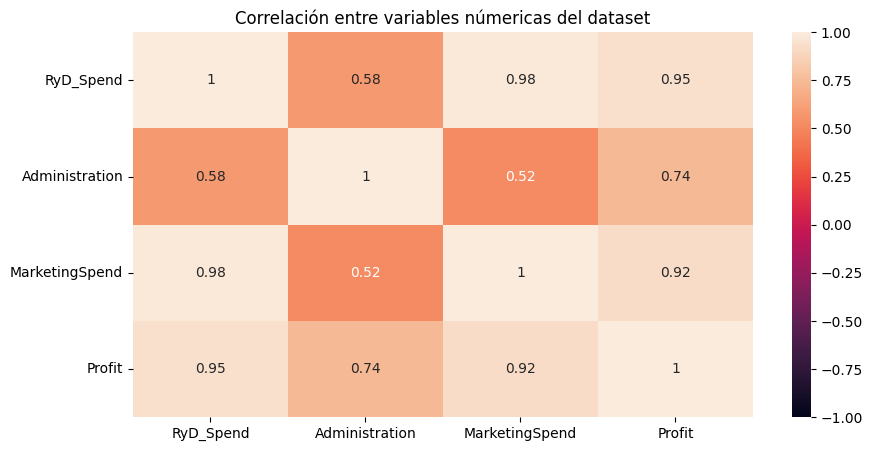

In [406]:
plt.figure(figsize=(10,5))
sns.heatmap(df1[cols1].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

A partir del gráfico se observa que las variables Administration y, en especial MarketingSpend están fuertemente  relacionadas con Profit, mientras que las demás variables no muestran asociaciones lineales significativas, cercanas a 0,5.


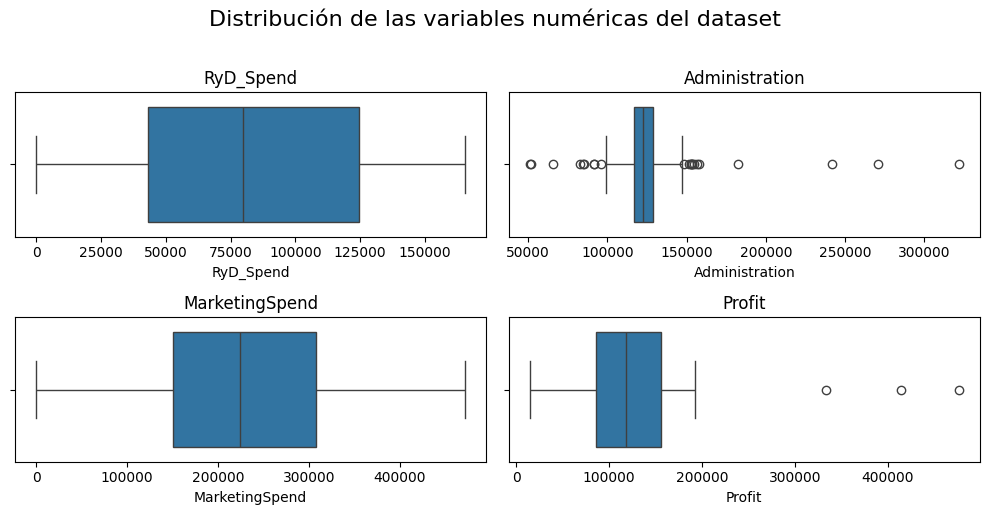

In [407]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

axes = axes.flatten()

for i, col in enumerate(cols1):
    sns.boxplot(x=df1[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Observando el gráfico de las distribución de las variables numéricas del dataset podemos ver que:
* Las variabales RyD_Spend y MarketingSpend no presentan valores atípicos.
* Las variables Profit y Administration presentan valores atípicos, que decidimos filtrar.

**Outliers**

In [408]:
df1 = df1[df1['Profit'] < df1['Profit'].quantile(0.997)]

In [409]:
df1 = df1[df1['Administration'] < df1['Administration'].quantile(0.99)]

**Codificación de variables catgorícas**

In [410]:
df1 = pd.get_dummies(data=df1, columns=['State'])

df1

,RyD_Spend,Administration,MarketingSpend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.8000,471784.1000,192261.83000,False,False,True
2,153441.51,101145.5500,407934.5400,191050.39000,False,True,False
3,144372.41,118671.8500,383199.6200,182901.99000,False,False,True
4,142107.34,91391.7700,366168.4200,166187.94000,False,True,False
5,131876.90,99814.7100,362861.3600,156991.12000,False,False,True
...,...,...,...,...,...,...,...
992,105127.00,125982.7298,271621.8728,138841.98810,False,True,False
993,46798.00,117368.4374,159075.9080,89012.02672,True,False,False
994,97209.00,124813.3635,256344.0701,132077.70900,False,False,True
995,54135.00,118451.9990,173232.6695,95279.96251,True,False,False


In [411]:
df1.columns

Index(['RyD_Spend', 'Administration', 'MarketingSpend', 'Profit',
       'State_California', 'State_Florida', 'State_New York'],
      dtype='object')

**División test - train**

In [412]:
cols_bool = ['State_California', 'State_Florida', 'State_New York']
cols_num = ['RyD_Spend', 'Administration', 'MarketingSpend']

X1 = df1.drop(columns=['Profit'])
y1 = df1['Profit']

X1[cols_bool] = X1[cols_bool].astype('int')

In [413]:
X_train1, X_test1, y_train1, y_test1  = train_test_split(X1, y1, test_size=0.2, random_state=13)
X_train4, X_test4, y_train4, y_test4  = train_test_split(X1, y1, test_size=0.3, random_state=13)

## Árbol de decisión

**Optimización del árbol**

In [414]:
param_grid = {
    'max_depth': [5, 7, 10, 15, 20, None],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 5, 7, 10],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
}
random_search = RandomizedSearchCV(DecisionTreeRegressor(), param_distributions=param_grid)
random_search.fit(X_train1, y_train1)
# Mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_
# Entrenamos el modelo con estos hiperparámetros

print(f'{first_best_params}')

{'min_samples_split': 10, 'min_samples_leaf': 7, 'max_depth': 15, 'criterion': 'absolute_error'}


**Mejor modelo**

In [415]:
max_depth = first_best_params['max_depth']
criterion = first_best_params['criterion']
min_samples_leaf = first_best_params['min_samples_leaf']
min_samples_split = first_best_params['min_samples_split']

tree_reg = DecisionTreeRegressor(criterion=criterion, 
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf, 
                                  min_samples_split=min_samples_split,
                                  random_state=13)

### Dataset 1 (80, 20)

In [416]:
tree_reg.fit(X_train1, y_train1)

,criterion,'absolute_error'
,splitter,'best'
,max_depth,15
,min_samples_split,10
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [417]:
pred_train = tree_reg.predict(X_train1)

pred_test = tree_reg.predict(X_test1)

tableResult(y_test1, pred_test)

,Actual,Predicted
613,138213.22960,138817.640800
884,63978.72668,63702.790565
811,167391.55140,168285.140200
295,174329.25160,174421.515100
594,54991.58145,55195.757090
...,...,...
423,185028.39680,185272.724100
270,170174.83270,169566.577200
54,89803.10053,90544.625440
496,66273.35330,67282.271410


### Visualización

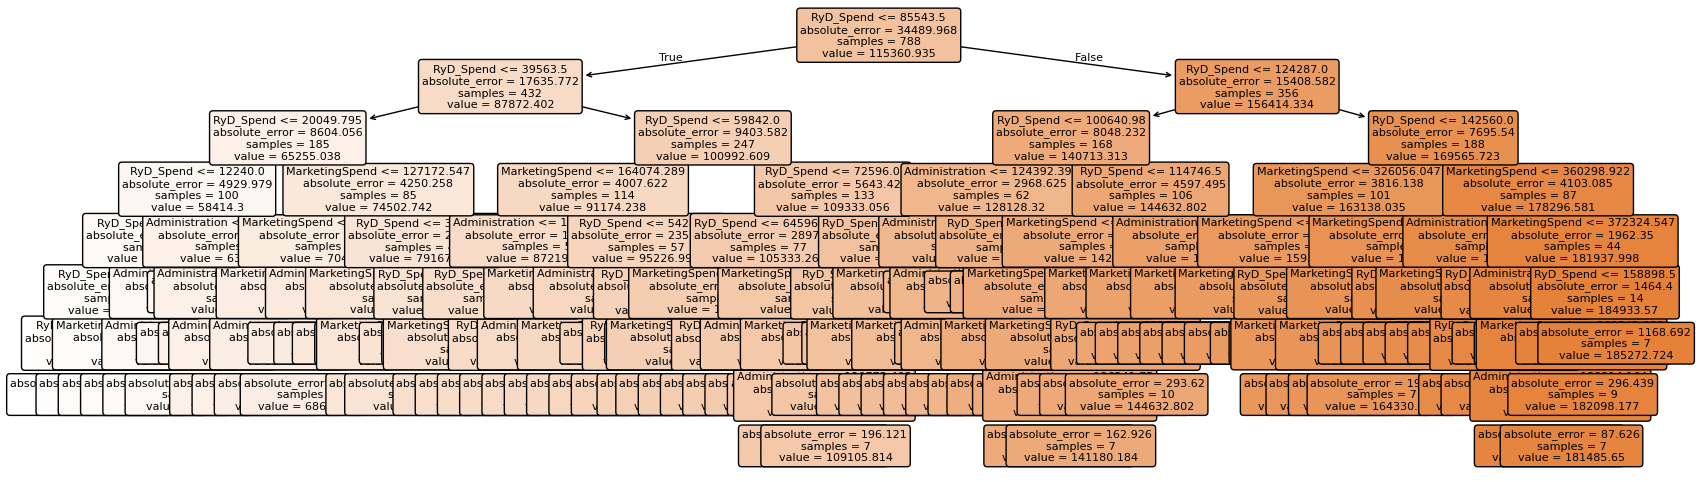

In [418]:
plt.figure(figsize=(20,6))
plot_tree(tree_reg, feature_names=X_train1.columns, fontsize=8, filled=True,
               rounded=True)
plt.show()

En este gráfico se visualiza el árbol de decisión obtenido, el cuál se utilizará para hacer las predicciones.

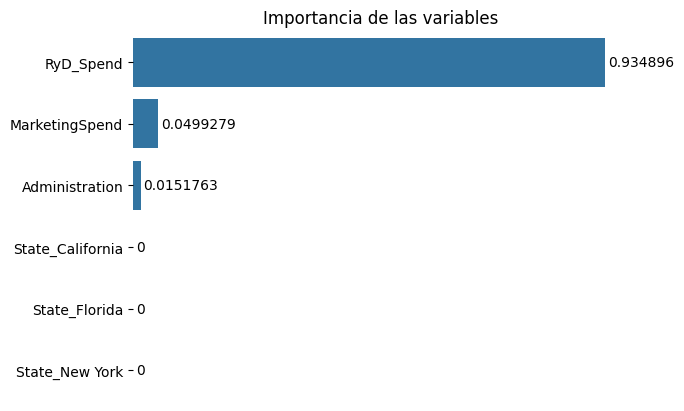

In [419]:
features_df = pd.DataFrame({'features': X_train1.columns,
                            'importances': tree_reg.feature_importances_ })

features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

El gráfico de importancia de variables muestra que si bien se utilizan 4 variables para realizar la predicción, la variable RyD_Spend es por amplio margen la que más influye, mientras que MarketingSpend, Administration, State_New York tienen un impacto casi nulo.

### Métricas

In [420]:
mape = np.mean(np.abs((y_test1 - pred_test) / y_test1) * 100)

print('Error absoluto medio:', mean_absolute_error(y_test1, pred_test))
print('Error medio cuadrado:', mean_squared_error(y_test1, pred_test))
print('Raíz del error medio cuadrado:', np.sqrt(mean_squared_error(y_test1, pred_test)))
print("Porcentaje de error medio absoluto (MAPE):", mape)

Error absoluto medio: 686.509600429293
Error medio cuadrado: 2018847.9904084576
Raíz del error medio cuadrado: 1420.8617069963063
Porcentaje de error medio absoluto (MAPE): 0.5954097174984996


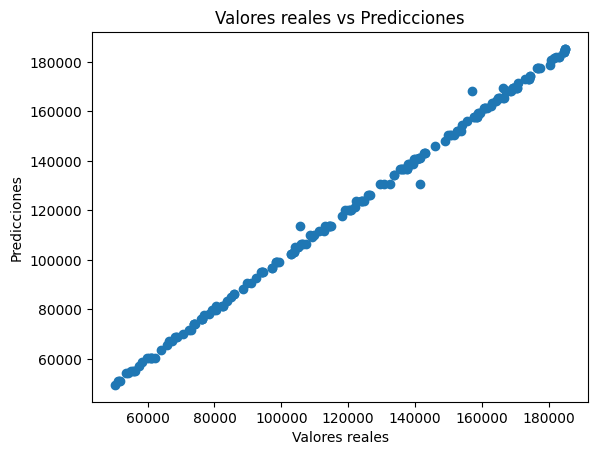

In [421]:
plt.scatter(y_test1, pred_test)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.show()

### Dataset 2 (70, 30)

In [422]:
tree_reg.fit(X_train4, y_train4)

,criterion,'absolute_error'
,splitter,'best'
,max_depth,15
,min_samples_split,10
,min_samples_leaf,7
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [423]:
pred_train4 = tree_reg.predict(X_train4)

pred_test4 = tree_reg.predict(X_test4)

tableResult(y_test4, pred_test4)

,Actual,Predicted
613,138213.22960,138841.988100
884,63978.72668,63702.790565
811,167391.55140,168285.140200
295,174329.25160,174421.515100
594,54991.58145,55195.757090
...,...,...
853,97955.60308,97409.283745
209,61393.64099,60154.491355
848,109877.23920,110295.841950
580,90482.26217,90238.361985


### Visualización

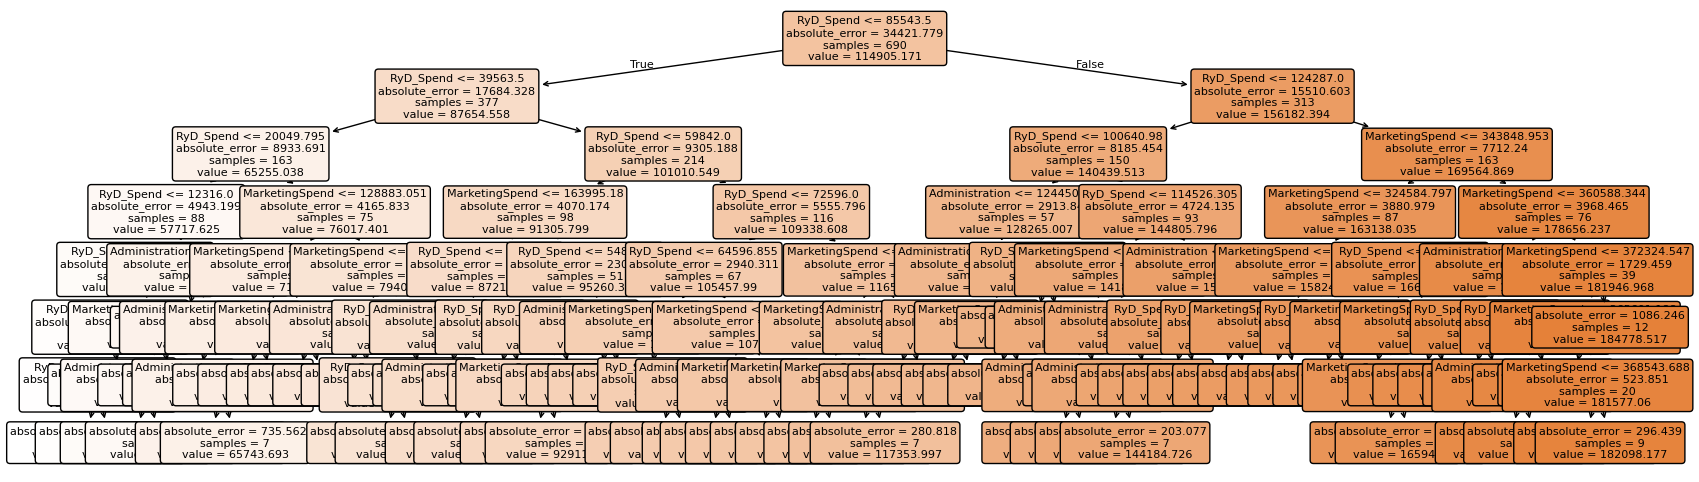

In [424]:
plt.figure(figsize=(20,6))
plot_tree(tree_reg, feature_names=X_train4.columns, fontsize=8, filled=True,
            rounded=True)
plt.show()

En este gráfico se visualiza el árbol de decisión obtenido, el cuál se utilizará para hacer las predicciones.

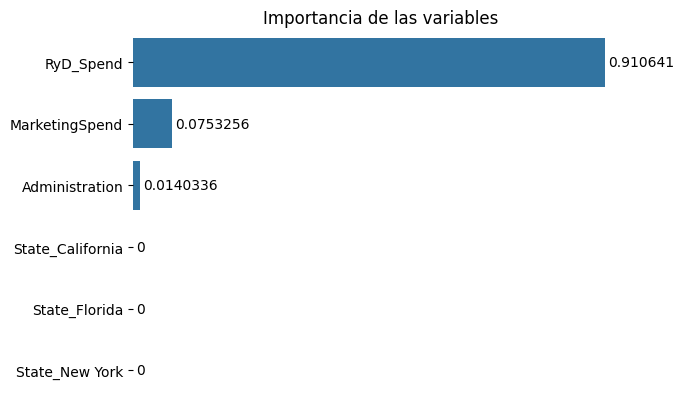

In [425]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': X_train4.columns,
                            'importances': tree_reg.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

El gráfico de importancia de variables muestra que si bien se utilizan 4 variables para realizar la predicción, la variable RyD_Spend es por amplio margen la que más influye, mientras que MarketingSpend, Administration, State_New York tienen un impacto casi nulo.

### Métricas

In [426]:
mape = np.mean(np.abs((y_test4 - pred_test4) / y_test4) * 100)

print('Error absoluto medio:', mean_absolute_error(y_test4, pred_test4))
print('Error medio cuadrado:', mean_squared_error(y_test4, pred_test4))
print('Raíz del error medio cuadrado:', np.sqrt(mean_squared_error(y_test4, pred_test4)))
print("Porcentaje de error medio absoluto (MAPE):", mape)

Error absoluto medio: 800.0842766047303
Error medio cuadrado: 3926684.0745391627
Raíz del error medio cuadrado: 1981.5862521069232
Porcentaje de error medio absoluto (MAPE): 0.7498762950942909


A comparación del entrenamiento del modelo con el dataset anterior, en este caso las métricas relacionadas al error dieron números menores, demostrando que los resultados al entrenarlo con el 

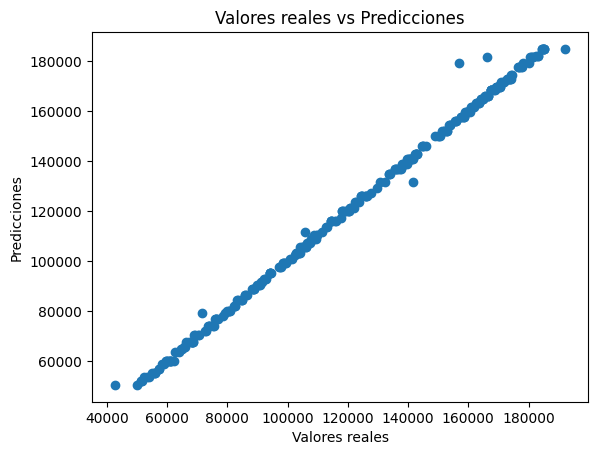

In [427]:
plt.scatter(y_test4, pred_test4)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Valores reales vs Predicciones")
plt.show()

matriz confision

# Segundo dataset

In [428]:
dataset2 = pd.read_csv('drugType.csv')

## Análisis exploratorio de datos (EDA)

In [429]:
#Creamos copia del dataset original
df2 = dataset2.copy()

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Edad        200 non-null    int64  
 1   Sexo        200 non-null    object 
 2   BP          200 non-null    object 
 3   Colesterol  200 non-null    object 
 4   Na_a_K      200 non-null    float64
 5   Droga       200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [430]:
df2.head()

,Edad,Sexo,BP,Colesterol,Na_a_K,Droga
0,23,F,Alto,Alto,25.355,DrogaY
1,47,M,Bajo,Alto,13.093,DrogaC
2,47,M,Bajo,Alto,10.114,DrogaC
3,28,F,Normal,Alto,7.798,DrogaX
4,61,F,Bajo,Alto,18.043,DrogaY


**Valores duplicados**

In [431]:
df2.duplicated().values.any()

False

**Valores faltantes**

In [432]:
df2.isna().sum()

Edad          0
Sexo          0
BP            0
Colesterol    0
Na_a_K        0
Droga         0
dtype: int64

**Distrubuciones de las variables**

In [433]:
cols2 = ['Na_a_K', 'Edad']

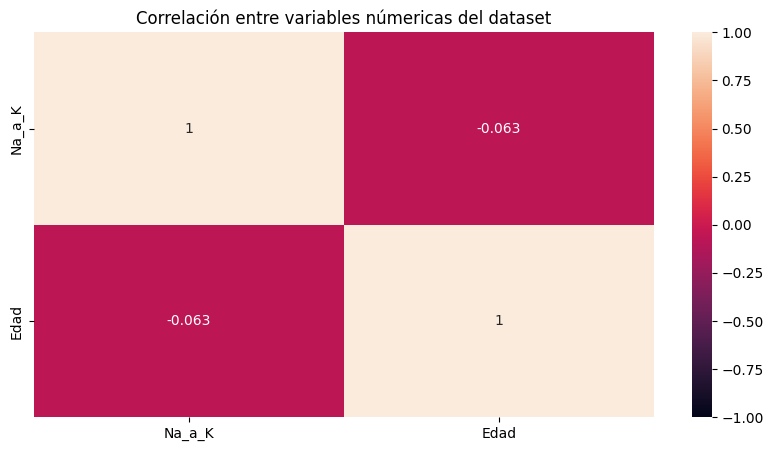

In [434]:
plt.figure(figsize=(10,5))
sns.heatmap(df2[cols2].corr(), vmin=-1, vmax=1, annot=True)
plt.title('Correlación entre variables númericas del dataset')
plt.show()

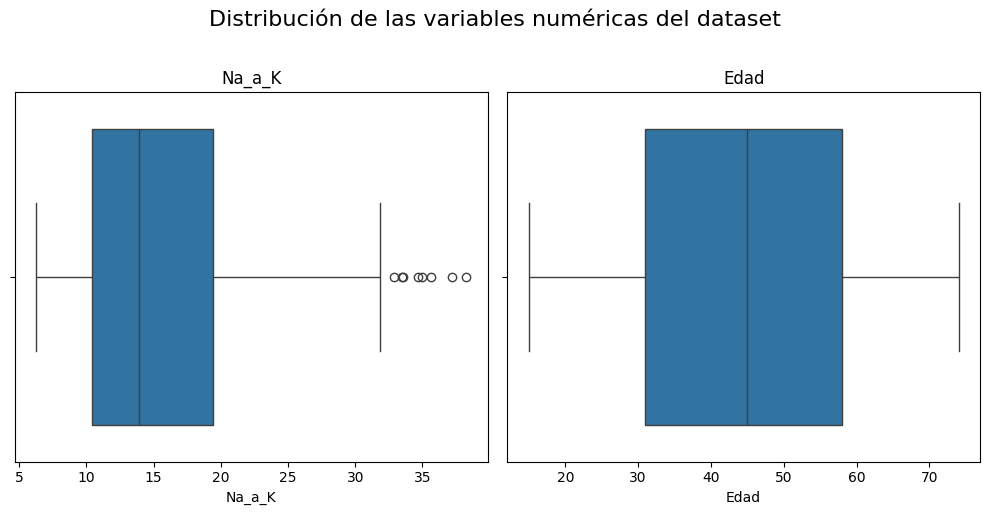

In [435]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes = axes.flatten()

for i, col in enumerate(cols2):
    sns.boxplot(x=df2[col], ax=axes[i], orient='h')
    axes[i].set_title(col)

fig.suptitle('Distribución de las variables numéricas del dataset', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Observando el gráfico de las distribución de las variables numéricas del dataset podemos ver que para la variable Edad no encontramos valores atípicos, mientras que para la variable Na_a_k si bien se encontraron valores atípicos, estos no son imposibles.


**Codificación de variables categóricas**

In [436]:
# Convertir columnas categóricas en numéricas
df2 = pd.get_dummies(data=df2, columns=['Sexo', 'BP', 'Colesterol'])

df2.head()

,Edad,Na_a_K,Droga,Sexo_F,Sexo_M,BP_Alto,BP_Bajo,BP_Normal,Colesterol_Alto,Colesterol_Normal
0,23,25.355,DrogaY,True,False,True,False,False,True,False
1,47,13.093,DrogaC,False,True,False,True,False,True,False
2,47,10.114,DrogaC,False,True,False,True,False,True,False
3,28,7.798,DrogaX,True,False,False,False,True,True,False
4,61,18.043,DrogaY,True,False,False,True,False,True,False


**División test - train**

In [437]:
X2 = df2.drop(columns=['Droga'])
y2 = df2['Droga']

In [438]:
X_train2, X_test2, y_train2, y_test2  = train_test_split(X2, y2, test_size=0.2, random_state=13, shuffle=True, stratify=y2)
X_train3, X_test3, y_train3, y_test3  = train_test_split(X2, y2, test_size=0.3, random_state=13, shuffle=True, stratify=y2)

**Análisis del balanceo de los dataset**

In [486]:
y_train2.value_counts(), y_test2.value_counts()

(Droga
 DrogaY    73
 DrogaX    43
 DrogaA    18
 DrogaC    13
 DrogaB    13
 Name: count, dtype: int64,
 Droga
 DrogaY    18
 DrogaX    11
 DrogaA     5
 DrogaB     3
 DrogaC     3
 Name: count, dtype: int64)

In [487]:
y_train3.value_counts(), y_test3.value_counts()

(Droga
 DrogaY    64
 DrogaX    38
 DrogaA    16
 DrogaC    11
 DrogaB    11
 Name: count, dtype: int64,
 Droga
 DrogaY    27
 DrogaX    16
 DrogaA     7
 DrogaC     5
 DrogaB     5
 Name: count, dtype: int64)

**Escalado de datos**

In [439]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, 19 to 72
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Edad               40 non-null     int64  
 1   Na_a_K             40 non-null     float64
 2   Sexo_F             40 non-null     bool   
 3   Sexo_M             40 non-null     bool   
 4   BP_Alto            40 non-null     bool   
 5   BP_Bajo            40 non-null     bool   
 6   BP_Normal          40 non-null     bool   
 7   Colesterol_Alto    40 non-null     bool   
 8   Colesterol_Normal  40 non-null     bool   
dtypes: bool(7), float64(1), int64(1)
memory usage: 1.2 KB


In [440]:
X_train_scaled2 = X_train2.copy()
X_test_scaled2 = X_test2.copy()

scaler = StandardScaler()

X_train_scaled2[['Edad', 'Na_a_K']] = scaler.fit_transform(X_train2[['Edad', 'Na_a_K']])
X_test_scaled2[['Edad', 'Na_a_K']] = scaler.transform(X_test2[['Edad', 'Na_a_K']])

X_train_scaled2.head()

,Edad,Na_a_K,Sexo_F,Sexo_M,BP_Alto,BP_Bajo,BP_Normal,Colesterol_Alto,Colesterol_Normal
83,-0.362829,-0.665798,True,False,True,False,False,False,True
65,1.453207,1.522411,True,False,False,False,True,False,True
74,-0.786571,0.133419,False,True,True,False,False,False,True
7,-0.181225,-0.706016,False,True,False,True,False,True,False
80,0.968931,-0.302859,False,True,True,False,False,True,False


In [441]:
X_train_scaled3 = X_train3.copy()
X_test_scaled3 = X_test3.copy()

X_train_scaled3[['Edad', 'Na_a_K']] = scaler.fit_transform(X_train3[['Edad', 'Na_a_K']])
X_test_scaled3[['Edad', 'Na_a_K']] = scaler.transform(X_test3[['Edad', 'Na_a_K']])

X_train_scaled3.head()

,Edad,Na_a_K,Sexo_F,Sexo_M,BP_Alto,BP_Bajo,BP_Normal,Colesterol_Alto,Colesterol_Normal
39,-1.725205,-0.990332,False,True,False,False,True,True,False
129,-0.699477,-1.222585,True,False,False,False,True,True,False
71,-0.940825,0.540342,True,False,False,False,True,True,False
174,-0.096108,-0.458187,False,True,True,False,False,False,True
125,-1.483857,1.449988,True,False,True,False,False,False,True


## Árbol de decisión

**Optimización de hiperparámetros**

In [443]:
param_grid = {
    'max_depth': [5, 7, 10, 15, None],
    'min_samples_split': [3, 5, 7, 9, 11, 13, 15],
    'min_samples_leaf': [3, 5, 7, 9, 11, 13, 15],
    'criterion': ['entropy', 'log_loss', 'gini'],
    'random_state': [13]
}
random_search = RandomizedSearchCV(DecisionTreeClassifier(), param_distributions=param_grid)
random_search.fit(X_train2, y_train2)
# Mejores hiperparámetros encontrados durante la búsqueda aleatoria
first_best_params = random_search.best_params_
# Entrenamos el modelo con estos hiperparámetros
best_prediction = random_search.predict(X_test2)
test_accuracy = accuracy_score(y_test2, best_prediction)

print(f'{first_best_params} \n {test_accuracy}')

{'random_state': 13, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_depth': 15, 'criterion': 'gini'} 
 0.975


**Mejor modelo**

In [444]:
max_depth = first_best_params['max_depth']
criterion = first_best_params['criterion']
min_samples_leaf = first_best_params['min_samples_leaf']
min_samples_split = first_best_params['min_samples_split']

tree_clf = DecisionTreeClassifier(criterion=criterion, 
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf, 
                                  min_samples_split=min_samples_split,
                                  random_state=13, 
                                  class_weight= 'balanced')

### Dataset 1: (80, 20)

In [445]:
tree_clf.fit(X_train2, y_train2)

,criterion,'gini'
,splitter,'best'
,max_depth,15
,min_samples_split,7
,min_samples_leaf,9
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [446]:
pred_train = tree_clf.predict(X_train2)

pred_test2 = tree_clf.predict(X_test2)

tableResult(y_test2, pred_test2).head()

,Actual,Predicted
19,DrogaY,DrogaY
50,DrogaY,DrogaY
99,DrogaY,DrogaY
41,DrogaB,DrogaB
30,DrogaX,DrogaX


**Visualización**

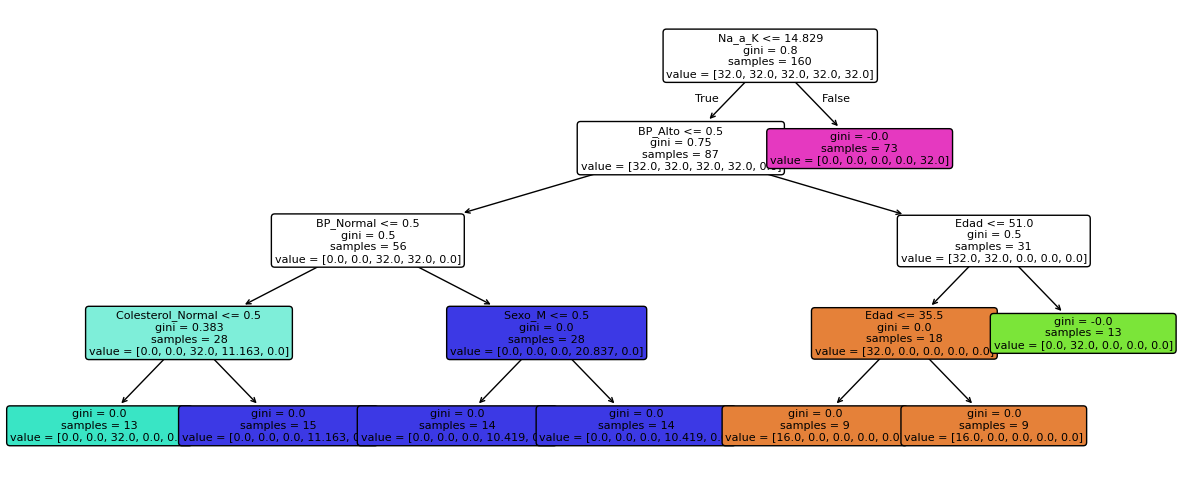

In [447]:
plt.figure(figsize=(15,6))
plot_tree(tree_clf, feature_names=X_train2.columns, fontsize=8, filled=True,
               rounded=True)
plt.show()

En este gráfico se visualiza el árbol de decisión obtenido, el cuál se utilizará para hacer las predicciones.

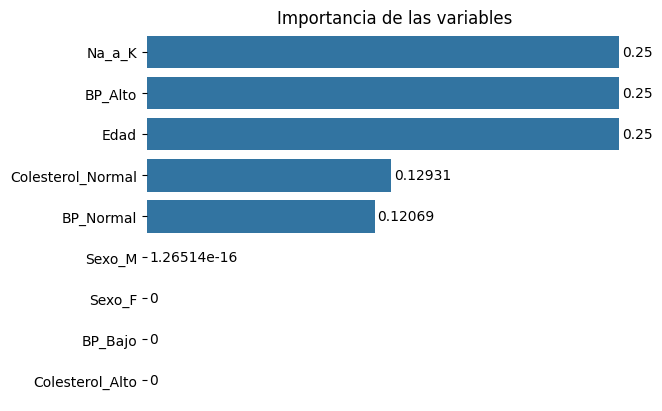

In [ ]:
features_df = pd.DataFrame({'features': X_train2.columns,
                            'importances': tree_clf.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

**Métricas**

In [449]:
print('Accuracy:', accuracy_score(y_test2, pred_test2))
print('Presision:', precision_score(y_test2, pred_test2, average='weighted'))
print('Recall:', recall_score(y_test2, pred_test2, average='weighted'))
print("F1:", f1_score(y_test2, pred_test2, average='weighted'))

Accuracy: 0.975
Presision: 0.9791666666666667
Recall: 0.975
F1: 0.9736363636363636


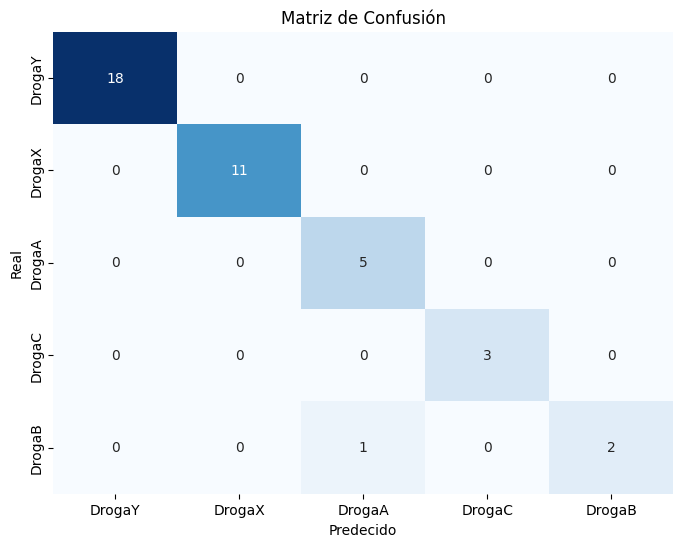

In [450]:
confusion = confusion_matrix(y_test2, pred_test2, labels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'],
            yticklabels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'],
            cbar=False)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

### Dataset 2: (70, 20)

In [451]:
tree_clf.fit(X_train3, y_train3)

,criterion,'gini'
,splitter,'best'
,max_depth,15
,min_samples_split,7
,min_samples_leaf,9
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,13
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [452]:
pred_train3 = tree_clf.predict(X_train3)

pred_test3 = tree_clf.predict(X_test3)

tableResult(y_test3, pred_test3).head()

,Actual,Predicted
93,DrogaY,DrogaY
35,DrogaX,DrogaX
150,DrogaA,DrogaA
152,DrogaX,DrogaX
137,DrogaA,DrogaA


**Visualización**

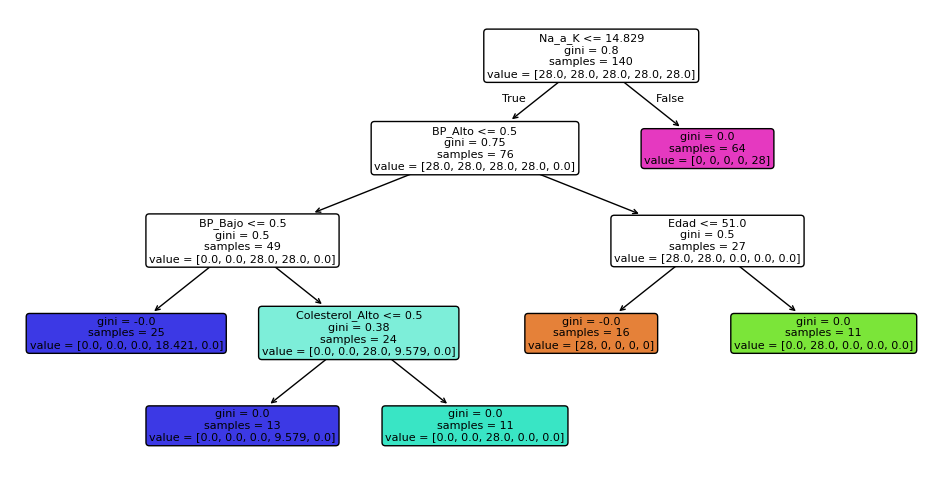

In [488]:
plt.figure(figsize=(12,6))
plot_tree(tree_clf, feature_names=X_train3.columns, fontsize=8, filled=True,
               rounded=True)
plt.show()

En este gráfico se visualiza el árbol de decisión obtenido, el cuál se utilizará para hacer las predicciones.

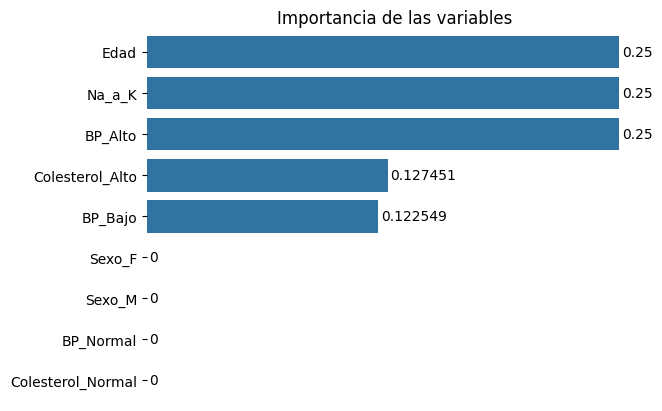

In [454]:
# Creo un df con dos columnas -> Caracteristica y ganacia de información
features_df = pd.DataFrame({'features': X_train3.columns,
                            'importances': tree_clf.feature_importances_ })

# Ordeno en base a la importancia
features_df_sorted = features_df.sort_values(by='importances', ascending=False)

g = sns.barplot(data=features_df_sorted, x='importances', y ='features')
sns.despine(bottom = True, left = True)
g.set_title('Importancia de las variables')
g.set(xlabel=None, ylabel=None, xticks=[])
for value in g.containers:
    g.bar_label(value, padding=2)

**Métricas**

In [ ]:
print('Accuracy:', accuracy_score(y_test3, pred_test3))
print('Presision:', precision_score(y_test3, pred_test3, average='weighted'))
print('Recall:', recall_score(y_test3, pred_test3, average='weighted'))
print("F1:", f1_score(y_test3, pred_test3, average='weighted'))

Accuracy: 0.9833333333333333
Presision: 0.9854166666666667
Recall: 0.9833333333333333
F1: 0.9829629629629629


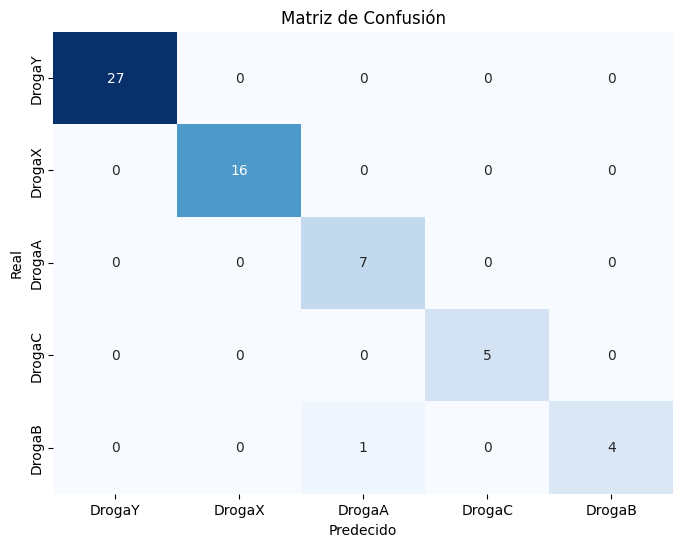

In [456]:
confusion = confusion_matrix(y_test3, pred_test3, labels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'],
            yticklabels=['DrogaY', 'DrogaX', 'DrogaA', 'DrogaC', 'DrogaB'],
            cbar=False)
plt.xlabel('Predecido')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Multinomial Naïve Bayes

### Dataset 1 (80, 20)

In [458]:
X_test2['edad_menor25'] = (X_test2['Edad'] < 25).astype(int)
X_test2['edad_25_50'] = ((X_test2['Edad'] >= 25) & (X_test2['Edad'] < 50)).astype(int)
X_test2['edad_50_75'] = ((X_test2['Edad'] >= 50) & (X_test2['Edad'] < 75)).astype(int)
X_test2['edad_mayor75'] = (X_test2['Edad'] >= 75).astype(int)

X_train2['edad_menor25'] = (X_train2['Edad'] < 25).astype(int)
X_train2['edad_25_50'] = ((X_train2['Edad'] >= 25) & (X_train2['Edad'] < 50)).astype(int)
X_train2['edad_50_75'] = ((X_train2['Edad'] >= 50) & (X_train2['Edad'] < 75)).astype(int)
X_train2['edad_mayor75'] = (X_train2['Edad'] >= 75).astype(int)

In [460]:
X_test2['NaK_bajo'] = (X_test2['Na_a_K'] < 10).astype(int)
X_test2['NaK_medio'] = ((X_test2['Na_a_K'] >= 10) & (X_test2['Na_a_K'] < 20)).astype(int)
X_test2['NaK_alto'] = (X_test2['Na_a_K'] >= 20).astype(int)

X_train2['NaK_bajo'] = (X_train2['Na_a_K'] < 10).astype(int)
X_train2['NaK_medio'] = ((X_train2['Na_a_K'] >= 10) & (X_train2['Na_a_K'] < 20)).astype(int)
X_train2['NaK_alto'] = (X_train2['Na_a_K'] >= 20).astype(int)

**Modelo**

In [461]:
clf_MNB = MultinomialNB()
clf_MNB.fit(X_train2, y_train2)

pred_MNB2 = clf_MNB.predict(X_test2)

**Métricas**

In [482]:
precision_MNB = precision_score(y_test2, pred_MNB2, average='weighted')
accuracy_MNB = accuracy_score(y_test2, pred_MNB2)
recall_MNB = recall_score(y_test2, pred_MNB2, average='weighted')

print(f'Precision: {precision_MNB}')
print(f'Accuracy: {accuracy_MNB}')
print(f'Recall: {recall_MNB}')

Precision: 0.8880482456140351
Accuracy: 0.875
Recall: 0.875


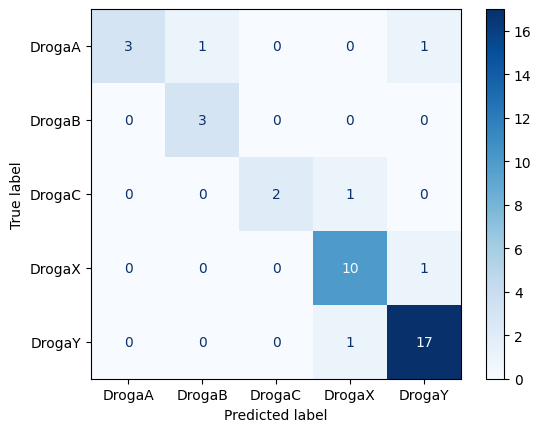

In [479]:
ConfusionMatrixDisplay.from_predictions(y_test2, pred_MNB2, cmap=plt.cm.Blues);

### Dataset 2 (70, 20)

In [465]:
X_test3['edad_menor25'] = (X_test3['Edad'] < 25).astype(int)
X_test3['edad_25_50'] = ((X_test3['Edad'] >= 25) & (X_test3['Edad'] < 50)).astype(int)
X_test3['edad_50_75'] = ((X_test3['Edad'] >= 50) & (X_test3['Edad'] < 75)).astype(int)
X_test3['edad_mayor75'] = (X_test3['Edad'] >= 75).astype(int)

X_train3['edad_menor25'] = (X_train3['Edad'] < 25).astype(int)
X_train3['edad_25_50'] = ((X_train3['Edad'] >= 25) & (X_train3['Edad'] < 50)).astype(int)
X_train3['edad_50_75'] = ((X_train3['Edad'] >= 50) & (X_train3['Edad'] < 75)).astype(int)
X_train3['edad_mayor75'] = (X_train3['Edad'] >= 75).astype(int)

In [466]:
X_test3['NaK_bajo'] = (X_test3['Na_a_K'] < 10).astype(int)
X_test3['NaK_medio'] = ((X_test3['Na_a_K'] >= 10) & (X_test3['Na_a_K'] < 20)).astype(int)
X_test3['NaK_alto'] = (X_test3['Na_a_K'] >= 20).astype(int)

X_train3['NaK_bajo'] = (X_train3['Na_a_K'] < 10).astype(int)
X_train3['NaK_medio'] = ((X_train3['Na_a_K'] >= 10) & (X_train3['Na_a_K'] < 20)).astype(int)
X_train3['NaK_alto'] = (X_train3['Na_a_K'] >= 20).astype(int)

**Modelo**

In [467]:
clf_MNB = MultinomialNB()
clf_MNB.fit(X_train3, y_train3)

pred_MNB3 = clf_MNB.predict(X_test3)

**Métricas**

In [484]:
precision_MNB = precision_score(y_test3, pred_MNB3, average='weighted')
accuracy_MNB = accuracy_score(y_test3, pred_MNB3)
recall_MNB = recall_score(y_test3, pred_MNB3, average='weighted')

print(f'Precision: {precision_MNB}')
print(f'Accuracy: {accuracy_MNB}')
print(f'Recall: {recall_MNB}')

Precision: 0.857375478927203
Accuracy: 0.8333333333333334
Recall: 0.8333333333333334


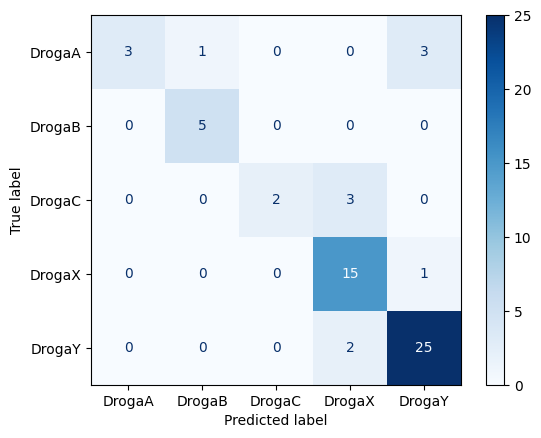

In [480]:
ConfusionMatrixDisplay.from_predictions(y_test3, pred_MNB3, cmap=plt.cm.Blues);

# KNN

### Dataset 1 (80, 20)

**Gráfico para decidir el mejor n**

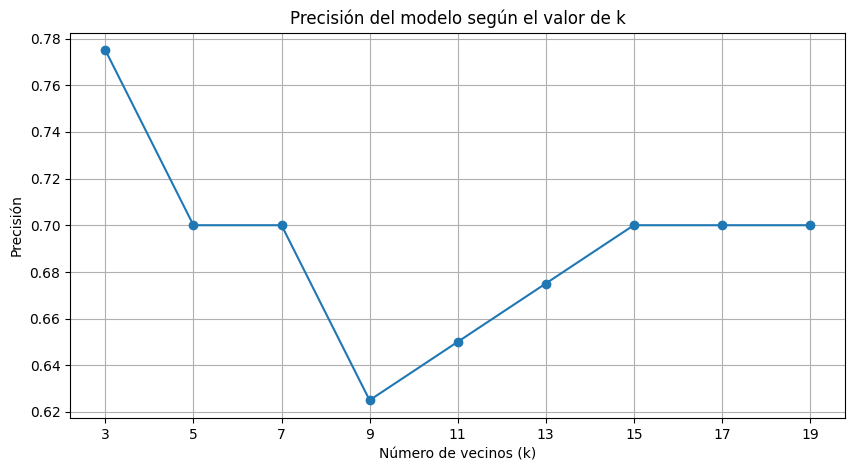

In [471]:
k_values = range(3, 21, 2) 
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train2, y_train2)
    predictions = knn.predict(X_test2)
    accuracies.append(accuracy_score(y_test2, predictions))

plt.figure(figsize=(10,5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Precisión')
plt.xticks([x for x in range(3, 21, 2)])
plt.title('Precisión del modelo según el valor de k')
plt.grid(True)
plt.show()

**Modelo**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train2, y_train2)

,n_neighbors,4
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [473]:
predictions = knn.predict(X_test2)

Precisión del modelo: 0.72

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.40      0.40      0.40         5
      DrogaB       0.33      0.33      0.33         3
      DrogaC       0.00      0.00      0.00         3
      DrogaX       0.62      0.73      0.67        11
      DrogaY       1.00      1.00      1.00        18

    accuracy                           0.72        40
   macro avg       0.47      0.49      0.48        40
weighted avg       0.69      0.72      0.71        40



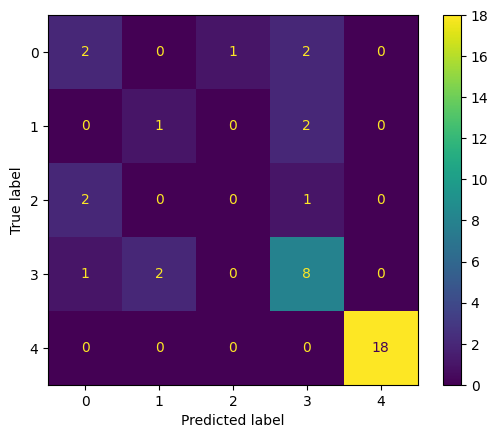

In [474]:
cm_knn = confusion_matrix(y_test2, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot()

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test2, predictions)
print(f'Precisión del modelo: {accuracy:.2f}')

# Mostrar el informe de clasificación
print('\nInforme de Clasificación:')
print(classification_report(y_test2, predictions))

### Dataset 2 (70, 30)

**Gráfico para decidir el mejor n**

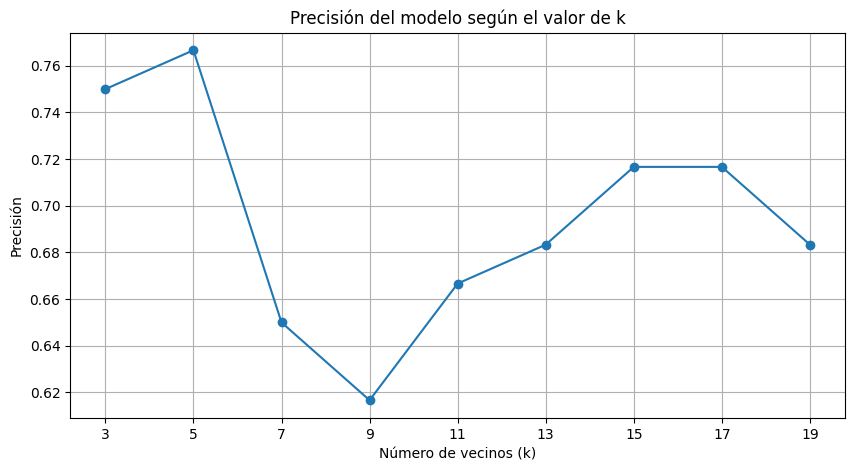

In [481]:
k_values = range(3, 21, 2)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train3, y_train3)
    predictions = knn.predict(X_test3)
    accuracies.append(accuracy_score(y_test3, predictions))

plt.figure(figsize=(10,5))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Número de vecinos (k)')
plt.ylabel('Precisión')
plt.xticks([x for x in range(3, 21, 2)])
plt.title('Precisión del modelo según el valor de k')
plt.grid(True)
plt.show()

**Modelo**

In [476]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train3, y_train3)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [477]:
predictions = knn.predict(X_test3)

Precisión del modelo: 0.77

Informe de Clasificación:
              precision    recall  f1-score   support

      DrogaA       0.67      0.29      0.40         7
      DrogaB       0.50      0.60      0.55         5
      DrogaC       0.67      0.40      0.50         5
      DrogaX       0.59      0.81      0.68        16
      DrogaY       1.00      0.96      0.98        27

    accuracy                           0.77        60
   macro avg       0.68      0.61      0.62        60
weighted avg       0.78      0.77      0.76        60



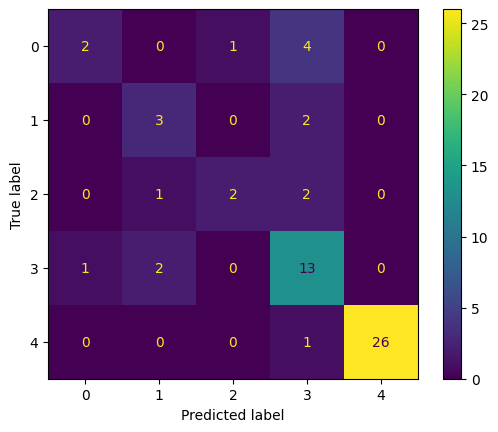

In [478]:
cm_knn = confusion_matrix(y_test3, predictions)
ConfusionMatrixDisplay(confusion_matrix=cm_knn).plot()

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test3, predictions)
print(f'Precisión del modelo: {accuracy:.2f}')

# Mostrar el informe de clasificación
print('\nInforme de Clasificación:')
print(classification_report(y_test3, predictions))